In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Kushirao123.",
                             database = "ecommerce")

cur  = db.cursor()

List all unique cities where customers are located

In [ ]:
query = """select distinct(customer_city) from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data  , columns = ["City"])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. COUNT THE NUMBER OF ORDERS PLACED IN THE YEAR 2017

In [ ]:
query = """select count(distinct(order_id)) from orders where year(order_purchase_timestamp) =  2017"""
cur.execute(query)
data = cur.fetchall()
print('Total Orders placed in 2017 are',data[0][0])

Total Orders placed in 2017 are 45101


3. FIND THE TOTAL SALES PER CATEGORY

In [ ]:
query = """

    SELECT products.product_category AS category, 
           ROUND(SUM(payments.payment_value), 2) AS sales
    FROM products 
    INNER JOIN order_items ON products.product_id = order_items.product_id
    INNER JOIN payments ON payments.order_id = order_items.order_id
    GROUP BY products.product_category

"""

cur.execute(query)

data = cur.fetchall()


df = pd.DataFrame(data , columns = ["Product" , "Total_Sales"])

df.head(10)

,Product,Total_Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
5,computer accessories,1585330.45
6,housewares,1094758.13
7,babies,539845.66
8,toys,619037.69
9,Furniture office,646826.49


WHAT IS THE PRODUCT CATEGORY WITH MAXIMUM SALES ??

In [ ]:
query = """
    SELECT t1.category , t1.sales from
    (SELECT products.product_category AS category, 
           ROUND(SUM(payments.payment_value), 2) AS sales
    FROM products 
    INNER JOIN order_items ON products.product_id = order_items.product_id
    INNER JOIN payments ON payments.order_id = order_items.order_id
    GROUP BY products.product_category) t1
    order by t1.sales desc
    limit 1

"""

cur.execute(query)

data = cur.fetchall()

print('Product category with maximum sales is',data[0][0],'with total sales of',data[0][1])

Product category with maximum sales is bed table bath with total sales of 1712553.67


CALCULATE THE PERCENTAGE OF ORDERS THAT WERE PLACED IN INSTALLMENT PAYMENTS

In [ ]:
query = """
select sum(case when payment_installments>=1 then 1 else 0 end)/count(*) * 100 from payments
"""

cur.execute(query)

data = cur.fetchall()

print('Total % of people placed orders by installment is',data[0][0],'%')

Total % of people placed orders by installment is 99.9981 %


CALCULATE THE PERCENTAGE OF ORDERS THAT WERE PLACED FOR 3 INSTALLMENT PAYMENTS

In [ ]:
query = """
select sum(case when payment_installments = 3 then 1 else 0 end) / count(*) * 100 from payments
"""
cur.execute(query)
data = cur.fetchall()
print('Total % of people placed orders by 3 installment is',data[0][0],'%')

Total % of people placed orders by 3 installment is 10.0697 %


COUNT THE NUMBER OF CUSTOMERS IN EACH STATE

In [ ]:
query = """
select customer_state state , count(*) total from ecommerce.customers group by customer_state
"""
cur.execute(query)

data = cur.fetchall()

df2 = pd.DataFrame(data,columns=["State","Total"])

df2.head(5)

,State,Total
0,SP,41746
1,SC,3637
2,MG,11635
3,PR,5045
4,RJ,12852


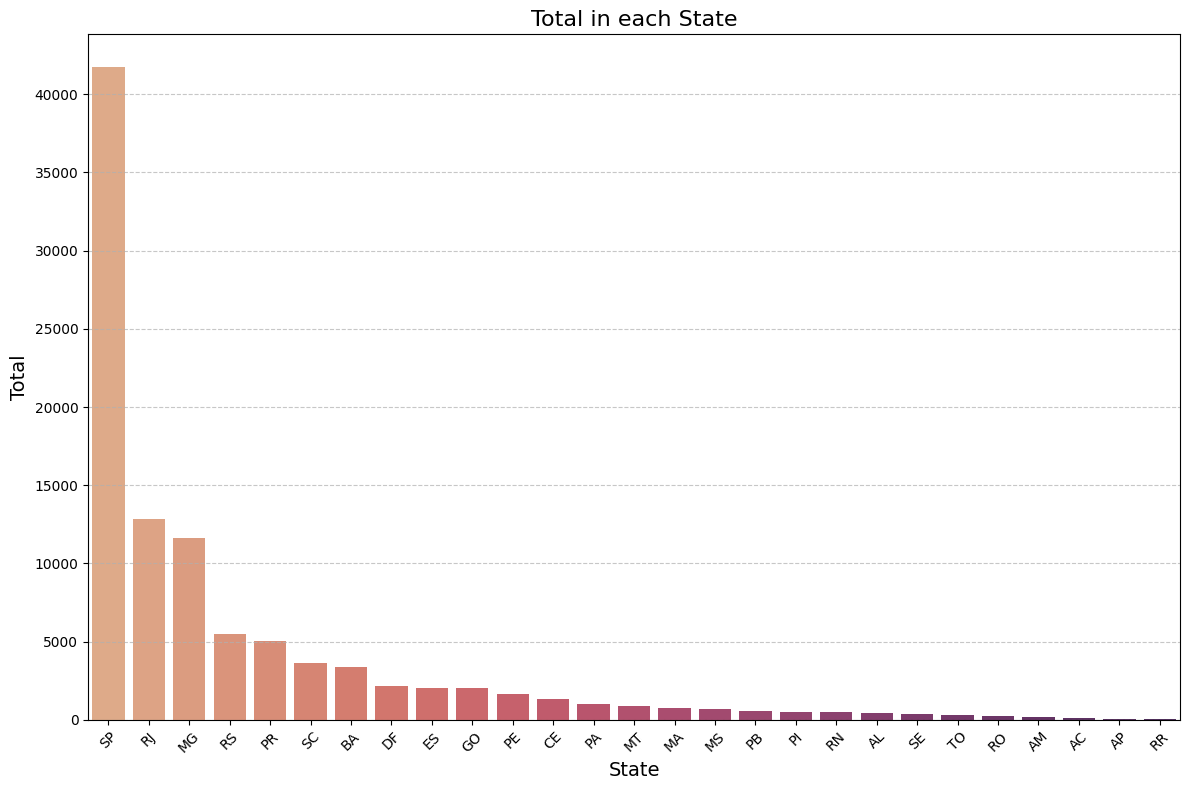

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
df2 = df2.sort_values(by="Total" , ascending = False)
sns.barplot(x='State', y='Total', data=df2, palette='flare')
plt.title('Total in each State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Total', fontsize=14)

plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


CALCULATE THE NUMBER OF ORDERS PER MONTH IN THE YEAR 2018

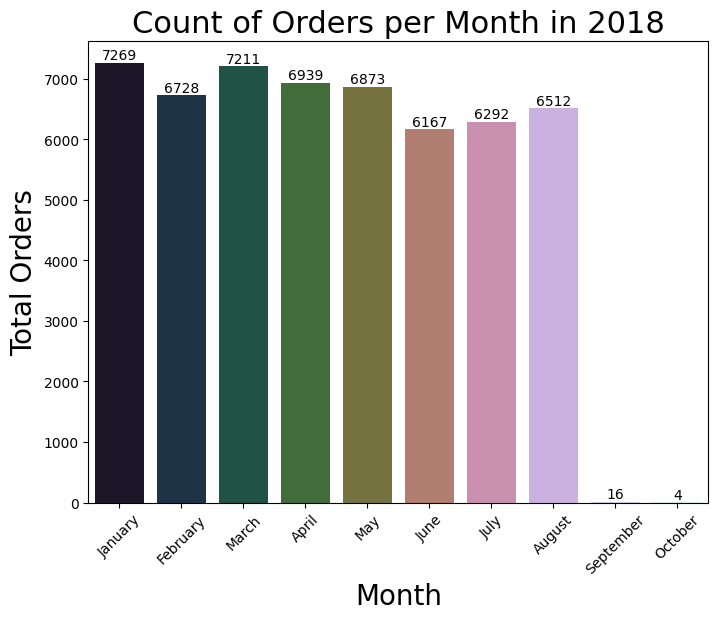

In [ ]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
""" 

cur.execute(query)
plt.figure(figsize=(8,6))
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
df = df.sort_values(by = "order_count",ascending = True)
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, palette='cubehelix')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.xlabel('Month' , fontsize = 20)
plt.ylabel('Total Orders' , fontsize = 20)
plt.title("Count of Orders per Month in 2018" , fontsize = 22)

plt.show()

FIND THE AVERAGE NUMBER OF PRODUCTS PER ORDER , GROUPED BY CUSTOMER CITY.

In [ ]:
query = """with t1 as (select o.order_id,o.customer_id, count(oi.order_id) as oc
from orders o join order_items oi
on o.order_id = oi.order_id
group by o.order_id,o.customer_id) 

select c.customer_city , round(avg(t1.oc),2) avg_order
from customers c join t1 
on c.customer_id = t1.customer_id 
group by c.customer_city
order by avg_order desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["City","Average Orders"])
df

,City,Average Orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


In [ ]:
print("City with highes average orders is" , df.loc[0,'City'])

City with highes average orders is padre carvalho


CALCULATE THE PERCENTAGE OF TOTAL_REVENUE CONTRIBUTED BY EACH PRODUCT CATEGORY

In [ ]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


Identify the correlation between product price and the number of times a product has been purchased.

In [ ]:
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


CALCULATE THE TOTAL REVENUE GENERATED BY EACH SELLER AND ARRANGE IN DESCENDING ORDER

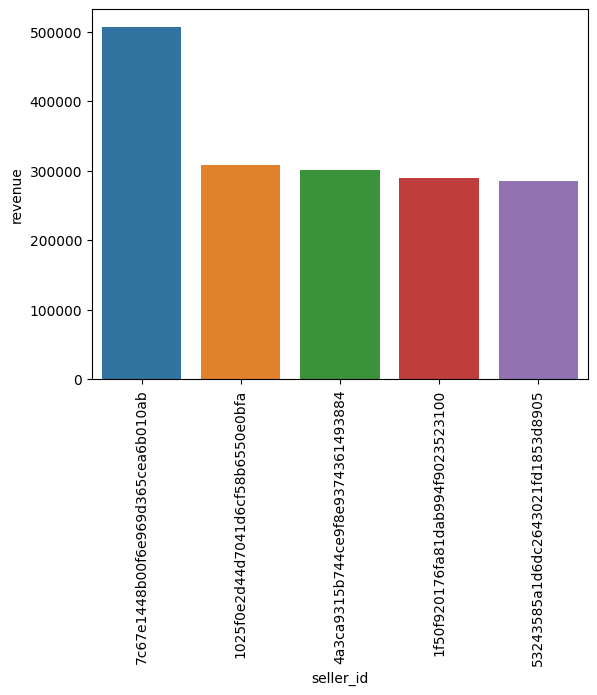

In [ ]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

CALCULATE THE CUMULATIVE SALES PER MONTH IN EACH YEAR

In [ ]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


Calculate the year-over-year growth rate of total sales.

In [ ]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


IDENTIFY THE TOP 3 CUSTOMERS WHO SPENT MORE MONEY EVERY YEAR

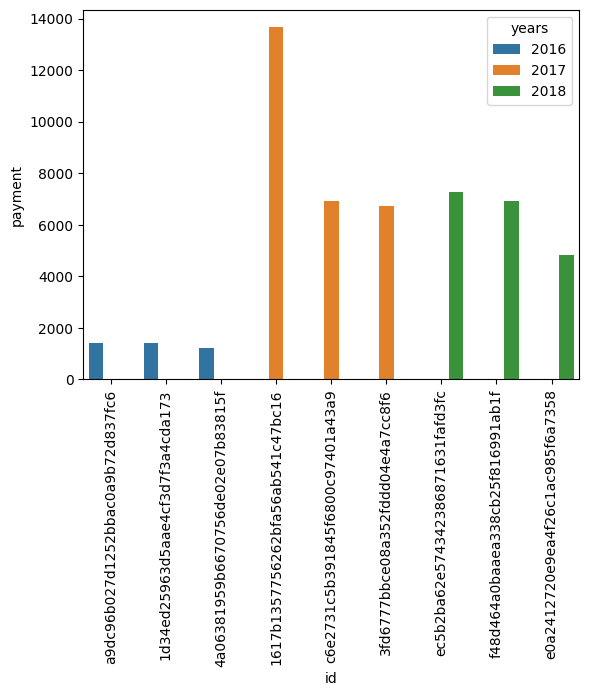

In [ ]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()

In [ ]:
#Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data